Here I am analysing the following data:
https://github.com/Plastic-Scanner/data/tree/main/data/20230302_avantes_spectrometer_third_dataset/

The analysis is mostly based off the work of https://pypi.org/project/pyspectra/

Author: Joost Scheffer @ 2023-03-14

In [1]:
!pip install -U scikit-learn, pyspectra

Defaulting to user installation because normal site-packages is not writeable
ERROR: Invalid requirement: 'scikit-learn,'


In [1]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspectra.transformers.spectral_correction import detrend, msc, snv
from sklearn.decomposition import PCA

In [2]:
!git clone https://github.com/Plastic-Scanner/data/

fatal: destination path 'data' already exists and is not an empty directory.


In [3]:
!ls data/data/20230302_avantes_spectrometer_third_dataset/

A01C_PET_FDP.csv   C01C_PVC_FDP.csv   E01C_PP_FDP.csv
A02C_PET_FDP.csv   C02C_PVC_FDP.csv   E02C_PP_FDP.csv
A03C_PET_FDP.csv   C03C_PVC_FDP.csv   E03C_PP_FDP.csv
A04C_PET_FDP.csv   C04C_PVC_FDP.csv   E04C_PP_FDP.csv
A05C_PET_FDP.csv   C05C_PVC_FDP.csv   E05C_PP_FDP.csv
B01C_HDPE_FDP.csv  C06C_PVC_FDP.csv   F01C_PS_FDP.csv
B02C_HDPE_FDP.csv  D01C_LDPE_FDP.csv  F02C_PS_FDP.csv
B03C_HDPE_FDP.csv  D02C_LDPE_FDP.csv  F03C_PS_FDP.csv
B04C_HDPE_FDP.csv  D03C_LDPE_FDP.csv  F04C_PS_FDP.csv
B05C_HDPE_FDP.csv  D04C_LDPE_FDP.csv  RefSpectrum_PlSc_FDP.csv


## load data

In [4]:
p = Path("data/data/20230302_avantes_spectrometer_third_dataset/")
files = list(p.glob(f"*.csv"))

In [5]:
ticks = [1050, 1200, 1300, 1450, 1550, 1650, 1720]

In [6]:
def snv_diy(x):
    return (x - np.mean(x)) / np.std(x)

In [7]:
types = set()
type_fnames = {}
for file in files:
    name, typ, _ = file.stem.split("_")
    if typ not in type_fnames:
        type_fnames[typ] = []
    type_fnames[typ].append(file.stem)
    types.add(typ)

type_color = {
    typ: col for typ,col in zip(types, ["r", "g", "b", "orange", "k", "m", "teal"])
}

## apply snv and baseline correction to each measurement, take the mean of each file

In [8]:
# maps filename stem to mean array of spectra
file_mean = {}

for file in files:
    wavelengths = np.loadtxt(file, skiprows=6, delimiter=",", usecols=[0])
    spectra = np.loadtxt(file, skiprows=6, delimiter=",", usecols=[1, 2, 3, 4, 5]).T
    spectra_snv = (spectra.T - np.mean(spectra, axis=1)) / np.std(spectra, axis=1)
    spectra_baseline_normal = np.apply_along_axis(
        lambda x: x.T - np.polyval(np.polyfit(wavelengths, x, deg=2), wavelengths),
        0,
        spectra_snv,
    ).T
    std_snv = np.std(spectra_snv, axis=1)
    std_norm = np.std(spectra_baseline_normal, axis=0)
    mean = np.mean(spectra_baseline_normal,axis=0)
    file_mean[file.stem] = mean

## example of raw, snv and baseline corrected for one plastic type

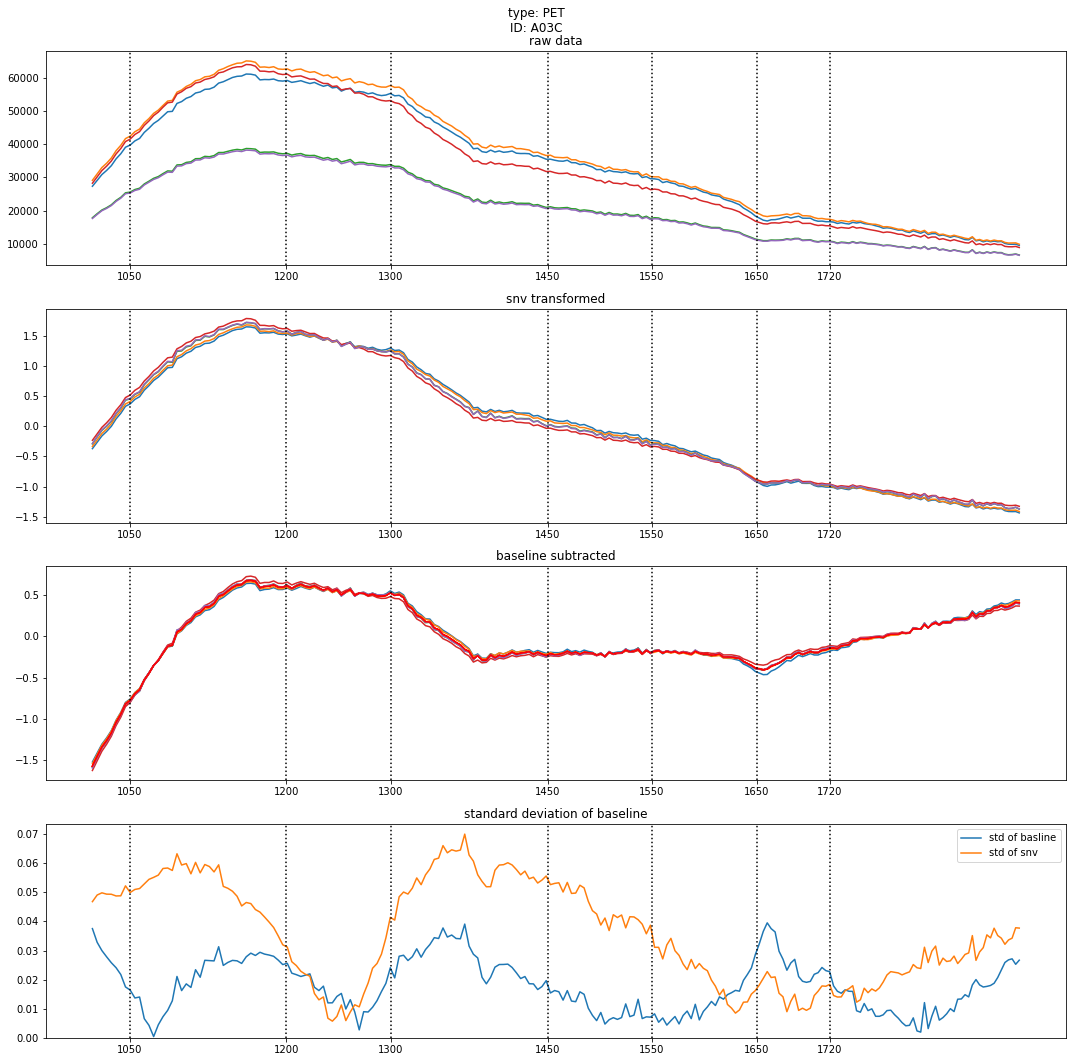

In [13]:
fig, ax = plt.subplots(4, 1, figsize=[15, 15])
for reg, snv, norm in zip(spectra, spectra_snv.T, spectra_baseline_normal):
    ax[0].plot(wavelengths, reg)
    ax[0].set_title("raw data")
    ax[1].plot(wavelengths, snv)
    ax[1].set_title("snv transformed")
    ax[2].plot(wavelengths, norm)
    ax[2].set_title("baseline subtracted")
    ax[2].plot(wavelengths, mean,c='r')

ax[3].plot(wavelengths, std_norm,label="std of basline")
ax[3].plot(wavelengths, std_snv,label="std of snv")
ax[3].legend()
ax[3].set_title("standard deviation of baseline")
ax[3].set_ylim(0)

ticks = [1050, 1200, 1300, 1450, 1550, 1650, 1720]
for axi in ax:
    for x in ticks:
        axi.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    axi.set_xticks(ticks, list(map(str, ticks)))

plt.suptitle(f"type: {file.stem.split('_')[1]}\nID: {file.stem.split('_')[0]}")
plt.tight_layout()

## the baseline corrected mean of each sample grouped per plastic type

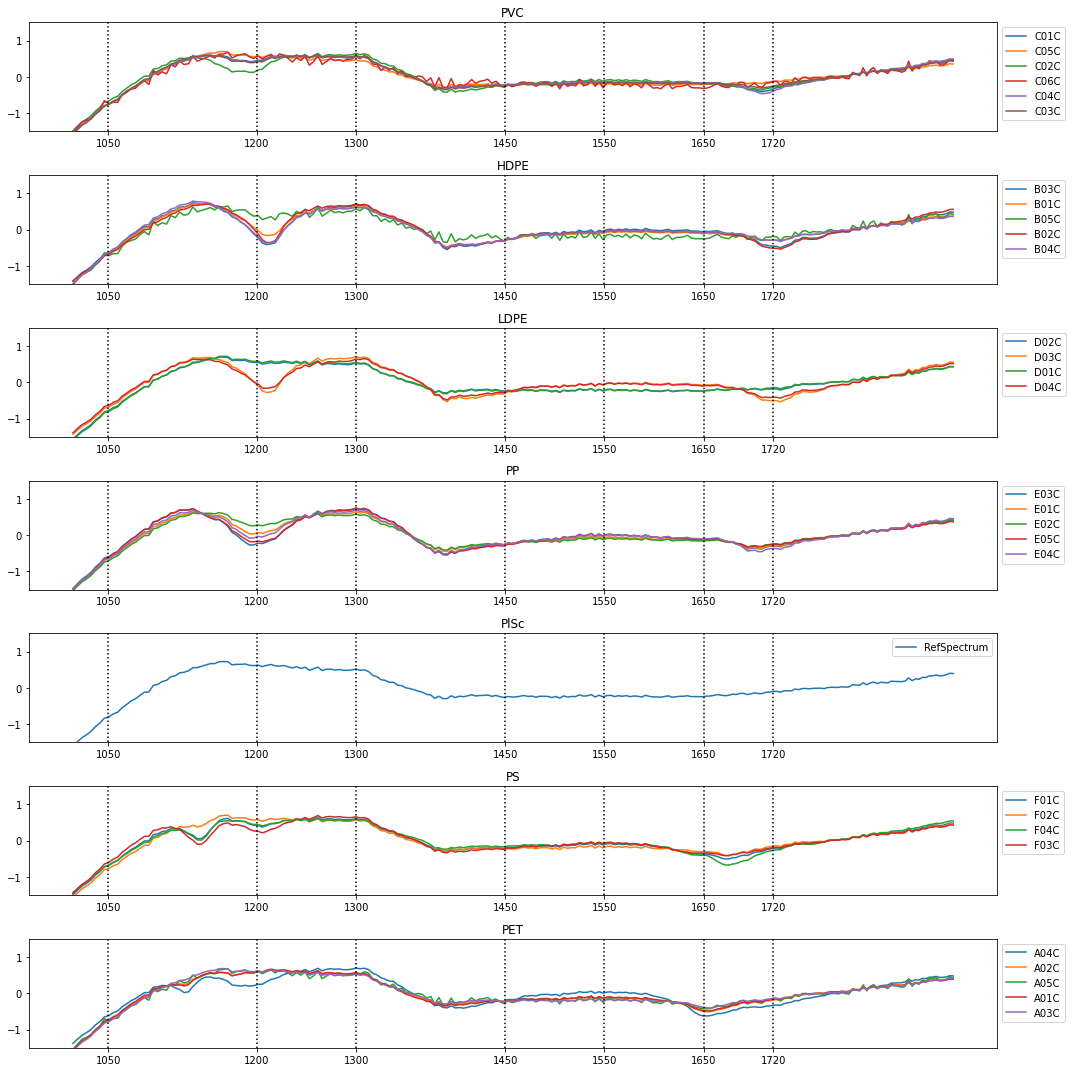

In [10]:
fig, axi = plt.subplots(len(types), 1, figsize=[15, 15])
for ax, typ in zip(axi, types):
    for fname in type_fnames[typ]:
        ax.plot(wavelengths, file_mean[fname], label=fname.split("_")[0])
    ax.set_title(typ)
    ax.legend(bbox_to_anchor=(1, 1))

    
    for x in ticks:
        ax.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
    ax.set_xticks(ticks, list(map(str, ticks)))
    ax.set_ylim(-1.5,1.5)

plt.tight_layout()

## all baseline corrected means on top of eachother

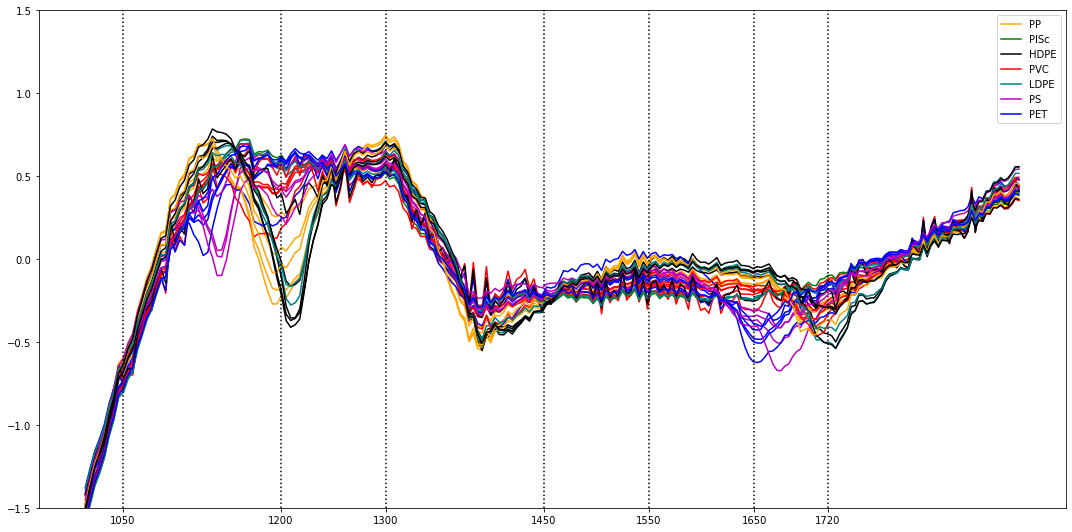

In [68]:
fig = plt.figure(figsize=[15, 7.5])
had = set()
for file in file_mean:
    mean = file_mean[file]
    typ = file.split('_')[1]
#     print(typ)
    color = type_color[typ]
    
    if typ not in had:
        plt.plot(wavelengths,mean,color=color,label=typ)
    else:
        plt.plot(wavelengths,mean,color=color)
    had.add(typ)

    
for x in ticks:
    plt.axvline(x=x, ymin=0, ymax=1, color="k", linestyle="dotted")
plt.xticks(ticks, list(map(str, ticks)))
plt.ylim(-1.5,1.5)
plt.legend()
plt.tight_layout()